In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
df = pd.read_excel("C:/Users/user/github/Data/hysteresis/Cyclic Hysteresis Acquisition/Vertical HT_Cyclic Hysteresis  Acquisition.xlsx", sheet_name=9)

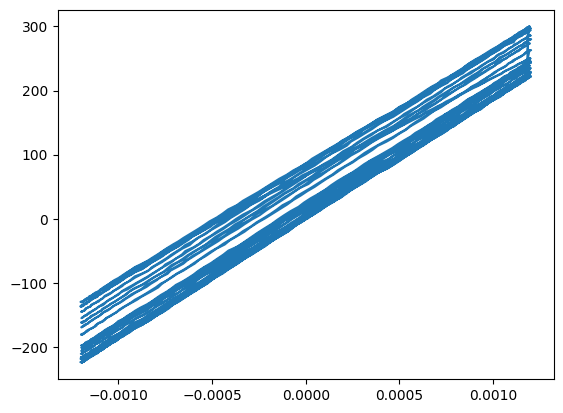

In [3]:
plt.plot(df.iloc[:,1], df.iloc[:,2])
plt.show()

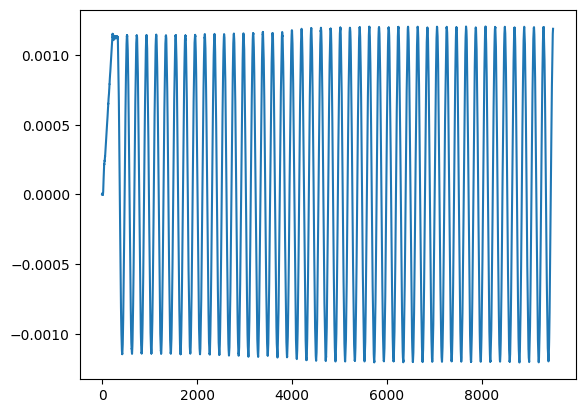

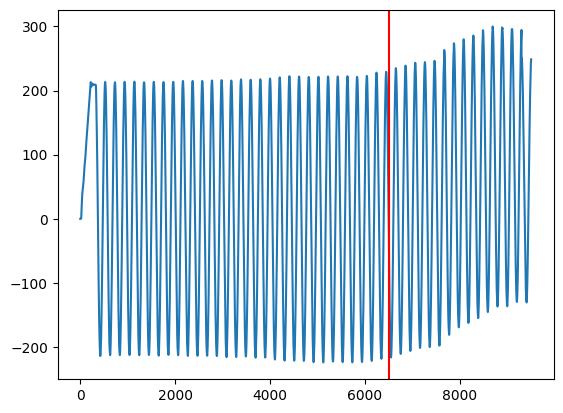

In [4]:
plt.plot(df.iloc[:,1])
plt.show()
plt.plot(df.iloc[:,2])
plt.axvline(x = 6500, color = 'r')
plt.show()

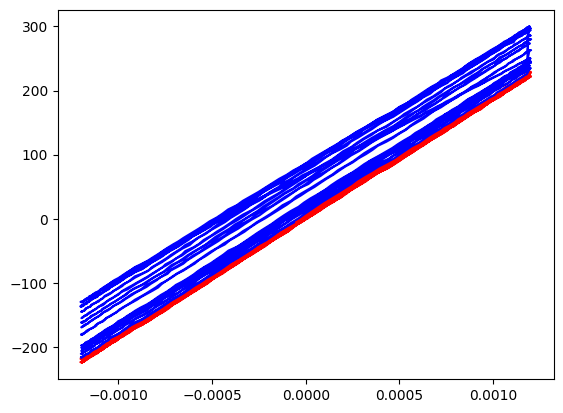

In [5]:
plt.plot(df.iloc[:6500,1], df.iloc[:6500,2], color = 'r')
plt.plot(df.iloc[6500:,1], df.iloc[6500:,2], color = 'b')
plt.show()

In [6]:
train = df[df.index <= 4000][['Strain','Stress']]
test = df[df.index>4000][['Strain','Stress']]

In [7]:
test

,Strain,Stress
4001,0.001170,218.090456
4002,0.001174,217.772727
4003,0.001166,217.114033
4004,0.001155,216.253140
4005,0.001156,215.339925
...,...,...
9499,0.001167,245.344634
9500,0.001170,246.477539
9501,0.001178,247.388812
9502,0.001180,247.990370


In [8]:
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수
gm = GaussianMixture(n_components=5, covariance_type = 'full',n_init=10, random_state=42)
gm.fit(train)

GaussianMixture(n_components=5, n_init=10, random_state=42)

In [9]:
q = pd.DataFrame(gm.fit_predict(test))

In [10]:
# 알고리즘이 수렴했는지 여부
gm.converged_

True

In [11]:
q = df[['Strain','Stress']]

In [12]:
densities = gm.score_samples(test)
density_threshold = np.percentile(densities, 50)
anomalies = test[densities < density_threshold]

In [13]:
anomalies

,Strain,Stress
4024,0.000840,156.495830
4025,0.000814,152.010446
4026,0.000795,147.443980
4027,0.000770,142.693691
4028,0.000738,137.570994
...,...,...
9468,0.000444,136.542933
9469,0.000486,142.005926
9470,0.000526,147.256480
9471,0.000548,152.503579


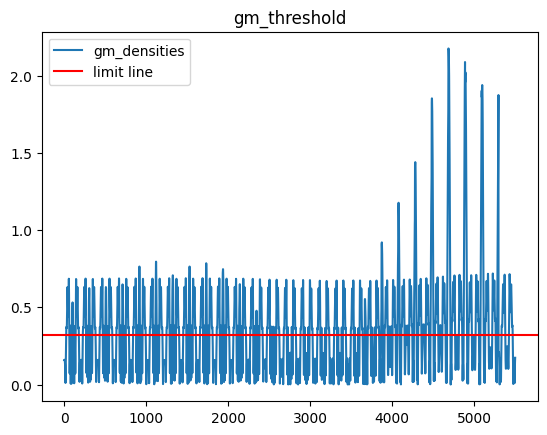

In [14]:
plt.plot(abs(densities), label = 'gm_densities')
plt.axhline(y = abs(density_threshold), color = 'r', label = 'limit line')
plt.title('gm_threshold')
plt.legend()
plt.show()

In [15]:
import sys
sys.path.append('C:/Users/User/github/Function/python/')

In [18]:
import eif as iso
import igraph as ig
from sklearn.model_selection import GridSearchCV

In [19]:
def branch2num(branch, init_root=0):
    num = [init_root]
    for b in branch:
        if b == 'L':
            num.append(num[-1] * 2 + 1)
        if b == 'R':
            num.append(num[-1] * 2 + 2)
    return num

In [20]:
def gen_graph(branches, g = None, init_root = 0, pre = ''):
    num_branches = [branch2num(i, init_root) for i in branches]
    all_nodes = [j for branch in num_branches for j in branch]
    all_nodes = np.unique(all_nodes)
    all_nodes = all_nodes.tolist()
    if g is None:
        g=ig.Graph()
    for k in all_nodes : g.add_vertex(pre+str(k))
    t=[]
    for j in range(len(branches)):
        branch = branch2num(branches[j], init_root)
        for i in range(len(branch)-1):
            pair = [branch[i],branch[i+1]]
            if pair not in t:
                t.append(pair)
                g.add_edge(pre+str(branch[i]),pre+str(branch[i+1]))
    return g,max(all_nodes)

In [21]:
param_grid = {'ntrees' : [50,100,150,200,250], 'limit' : [5,6,7,8,9,10,11]}

In [22]:
grid = GridSearchCV(iso.iForest, param_grid=param_grid, cv = 5)

In [23]:
F0  = iso.iForest(train.values, ntrees=300, limit=12, sample_size=256, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(train.values, ntrees=500, limit=12, sample_size=256, ExtensionLevel=1)
# F2  = iso.iForest(train.values, ntrees=500, limit=12, sample_size=256, ExtensionLevel=2)

In [24]:
S0 = F0.compute_paths(X_in=test.values)
S1 = F1.compute_paths(X_in=test.values)
# S2 = F2.compute_paths(X_in=df_ts_x)

Text(0.5, 1.0, 'extended1')

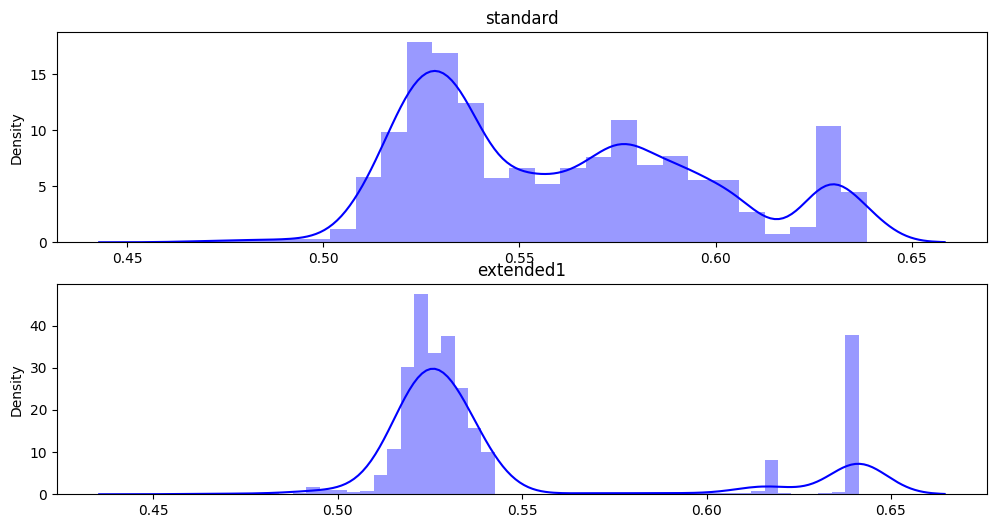

In [25]:
f = plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
sns.distplot(S0, kde=True, color="b")
plt.title('standard')

plt.subplot(2,1,2)
sns.distplot(S1, kde=True, color="b")
plt.title('extended1')


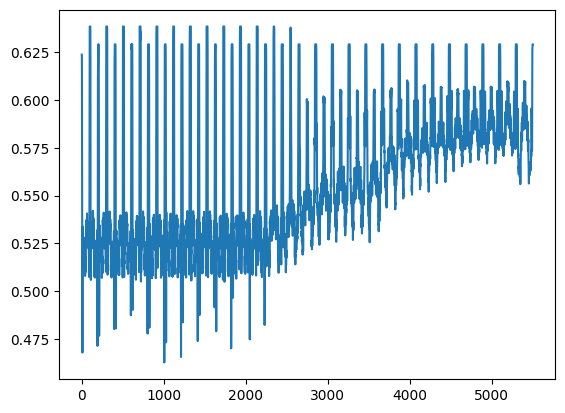

In [26]:
plt.plot(S0)

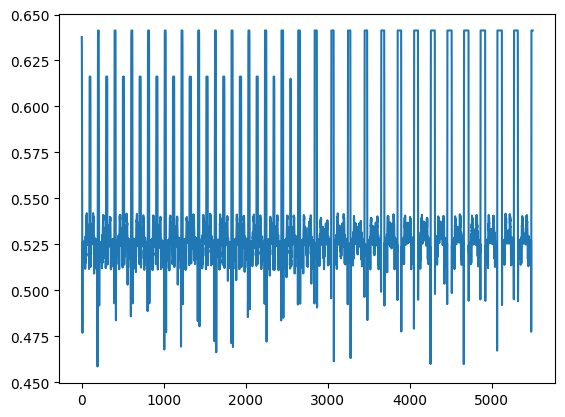

In [27]:
plt.plot(S1)

In [28]:
pd.DataFrame(S1)

,0
0,0.637766
1,0.633349
2,0.620707
3,0.594074
4,0.565666
...,...
5498,0.641314
5499,0.641314
5500,0.641314
5501,0.641314
